In [4]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import datetime as dt
import typing
from datetime import datetime, timedelta
plt.style.use('seaborn')
%matplotlib inline

In [2]:
google = pd.DataFrame(yf.download('googl', start = '2022-12-01')['Adj Close']).pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [7]:
d = pd.date_range(start='2023-02-02', end = '2023-02-17', freq='D')
len(d)

16

In [ ]:
start = '2023-02-02'
end = '2023-02-17'
date_range = pd.date_range(start = start, end = end , freq = 'B')
delta = date_range[-1] - date_range[0]
print("Time delta:", delta)

Time delta: 15 days 00:00:00


In [ ]:
delta

Timedelta('15 days 00:00:00')

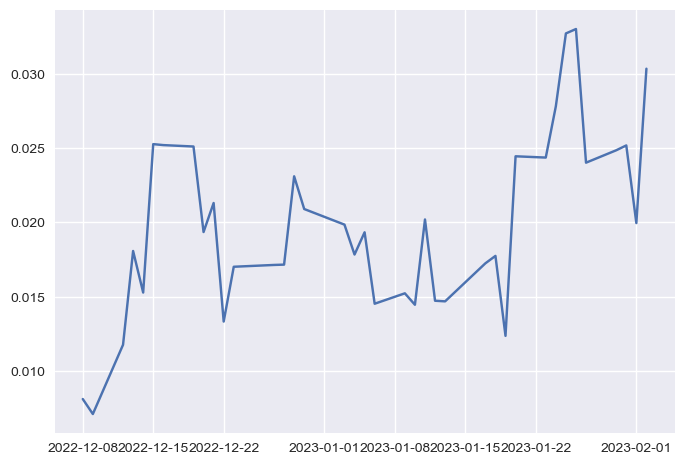

In [ ]:
plt.plot(google.rolling(5).std())
sigma_google = google.std()*np.sqrt(252)

In [ ]:
sigma_google

Adj Close    0.348379
dtype: float64

In [ ]:
def option(type = None, So = None, K = None, r = None, sigma = None, current_date = None, expiration_date = None):
    no_business_days = np.busday_count(begindates = current_date, enddates = expiration_date)
    Time = (no_business_days/252)
    # Divide by 252 because there are 252 trading days
    d1 = (np.log(So/K)+(r+((sigma**2)/2))*Time)/(sigma*np.sqrt(Time))
    d2 = d1 - sigma*np.sqrt(Time)
    present_value = K*(np.exp(-r*(Time)))
    if type == 'Call':
        price = So*(scs.norm.cdf(d1))-present_value*(scs.norm.cdf(d2))
    elif type == "Put":
        price = present_value*(scs.norm.cdf(-d2))-So*(scs.norm.cdf(-d1))
    else:
        print("Wrong security name")
    return pd.DataFrame([np.round(price,4)],columns = ['Option Price'])
        
        

In [21]:
def fx_options(spot_fx_rate: float,strike_fx_rate:float,sigma: float ,domestic_interest: float,foreign_interest:float,domestic_currency:str, foreign_currency:str, spot_date:str,expiration_date: str, option_type:str):
    tau = len(pd.date_range(start=spot_date,end = expiration_date))
    if domestic_currency == 'USD':
        t1 = tau/360
    else:
        t1 = tau/365
    if foreign_currency == 'USD':
        t2 = tau/360
    else:
        t2 = tau/365
    domestic_discount = np.exp(-domestic_interest*t1)
    foreign_discount = np.exp(-foreign_interest*t2)
    d1 =(np.log(spot_fx_rate/strike_fx_rate)+((domestic_interest-foreign_interest)+((sigma**2)/2))*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)

    if option_type == 'Call':
        price = spot_fx_rate*foreign_discount*(scs.norm.cdf(d1)) - strike_fx_rate*domestic_discount*(scs.norm.cdf(d2))

    elif option_type == 'Put':
        price = strike_fx_rate*domestic_discount*(scs.norm.cdf(-d2)) -spot_fx_rate*foreign_discount*(scs.norm.cdf(-d1))
    else:
        print('Wrong Option Type')

    return np.round(price,6)


    


In [37]:
fx_options(1.6,1.170,0.05,.0475,.0475,'EUR','GBP','2023-02-27','2023-02-28','Call')

0.429888

In [25]:
scs.norm.cdf(0)

0.5

In [ ]:
option('Call', So = 106.7,K = 95,r = .04,sigma = .5, current_date='2023-02-02',expiration_date='2023-02-17')

NameError: name 'option' is not defined

In [ ]:
option('Call', So = 112,K = 95,r = .0468,sigma = .5, current_date='2023-02-03',expiration_date='2023-02-17')

,Option Price
0,17.3773


In [ ]:
scs.norm.cdf(-.206)

0.4183954556526073